In [1]:
import torch, time, sys
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-single-force/'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, get_trajectory, dynamics_fn, hamiltonian_fn, arrange_data, get_field
from nn_models import MLP, PSD
from symoden import SymODEN_R
from hnn import HNN
from utils import L2_loss, from_pickle

from torchdiffeq import odeint
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')



In [2]:
DPI = 600
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 40
ARROW_WIDTH = 6e-3
LINE_WIDTH = 1


 ## Load models

In [3]:
# the symoden model
def get_model(args, baseline, structure, damping, num_points, gym=False):
    if structure == False and baseline == True:
        nn_model = MLP(args.input_dim, 600, args.input_dim, args.nonlinearity).to(device)    
        model = SymODEN_R(args.input_dim, H_net=nn_model, device=device, baseline=True)
    elif structure == False and baseline == False:
        H_net = MLP(args.input_dim, 400, 1, args.nonlinearity).to(device)
        g_net = MLP(int(args.input_dim/2), 200, int(args.input_dim/2)).to(device)
        model = SymODEN_R(args.input_dim, H_net=H_net, g_net=g_net, device=device, baseline=False)
    elif structure == True and baseline ==False:
        M_net = MLP(int(args.input_dim/2), 300, int(args.input_dim/2))
        V_net = MLP(int(args.input_dim/2), 50, 1).to(device)
        g_net = MLP(int(args.input_dim/2), 200, int(args.input_dim/2)).to(device)
        model = SymODEN_R(args.input_dim, M_net=M_net, V_net=V_net, g_net=g_net, device=device, baseline=False, structure=True).to(device)
    else:
        raise RuntimeError('argument *baseline* and *structure* cannot both be true')
    model_name = 'baseline_ode' if baseline else 'hnn_ode'
    struct = '-struct' if structure else ''
    rad = '-rad' if args.rad else ''
    path = '{}pend-{}{}-{}-p{}{}.tar'.format(args.save_dir, model_name, struct, args.solver, num_points, rad)
    model.load_state_dict(torch.load(path, map_location=device))
    path = '{}/pend-{}{}-{}-p{}-stats{}.pkl'.format(args.save_dir, model_name, struct, args.solver, num_points, rad)
    stats = from_pickle(path)
    return model, stats

# the hnn model
def get_hnn_model(args, baseline):
    output_dim = args.input_dim if args.baseline else 2
    nn_model = MLP(args.input_dim, 400, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,
                field_type=args.field_type, baseline=args.baseline)

    label = '-baseline' if args.baseline else '-hnn'
    label = label + '-rad' if args.rad else label
    path = '{}/{}{}.tar'.format(args.save_dir, args.name, label)
    return model

In [4]:
def get_args():
    return {'input_dim': 2,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'baseline': False,
         'field_type': 'solenoidal',
         'name': 'pend',
         'gridsize': 10,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures',
         'num_points': 2,
         'gpu': 0,
         'solver': 'rk4',
         'rad': False,
         'gym': False}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

args = ObjectView(get_args())


symoden_ode_model, symoden_ode_stats = get_model(args, baseline=False, structure=False, damping=False, num_points=args.num_points, gym=args.gym)
hnn_model = get_hnn_model(args, baseline=False)

def get_args():
    return {'input_dim': 2,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'baseline': False,
         'field_type': 'solenoidal',
         'name': 'pend',
         'gridsize': 10,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures',
         'num_points': 2,
         'gpu': 0,
         'solver': 'rk4',
         'rad': True,
         'gym': False}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

args = ObjectView(get_args())


symoden_ode_rad_model, symoden_ode_rad_stats = get_model(args, baseline=False, structure=False, damping=False, num_points=args.num_points, gym=args.gym)
hnn_rad_model = get_hnn_model(args, baseline=False)


 ## Functions to get train and prediction error

In [5]:
def get_loss(pred_x, pred_t_eval, model):
    pred_x = torch.tensor(pred_x, requires_grad=True, dtype=torch.float32).to(device) 
    pred_t_eval = torch.tensor(pred_t_eval, requires_grad=True, dtype=torch.float32).to(device)

    pred_loss = []
    for i in range(pred_x.shape[0]):
        pred_x_hat = odeint(model, pred_x[i, 0, :, :], pred_t_eval, method='rk4')            
        pred_loss.append((pred_x[i,:,:,:] - pred_x_hat)**2)
    
    pred_loss = torch.cat(pred_loss, dim=1)
    pred_loss_per_traj = torch.sum(pred_loss, dim=(0, 2))

    return pred_loss_per_traj.detach().cpu().numpy()

def get_hnn_loss(pred_x, pred_t_eval, model):
    pred_x = torch.tensor(pred_x, requires_grad=True, dtype=torch.float32).to(device) 
    pred_t_eval = torch.tensor(pred_t_eval, requires_grad=True, dtype=torch.float32).to(device)

    pred_loss = []
    for i in range(pred_x.shape[0]):
        pred_x_hat = odeint(model.int_wrapper, pred_x[i, 0, :, 0:2], pred_t_eval, method='rk4')            
        pred_loss.append((pred_x[i,:,:,0:2] - pred_x_hat)**2)
    
    pred_loss = torch.cat(pred_loss, dim=1)
    pred_loss_per_traj = torch.sum(pred_loss, dim=(0, 2))

    return pred_loss_per_traj.detach().cpu().numpy()


In [6]:
# get train loss
us = [0.0]
data = get_dataset(seed=args.seed, timesteps=45, rad=True,
            save_dir=args.save_dir, us=us, samples=50) #us=np.linspace(-2.0, 2.0, 20)

train_rad_x, train_rad_t_eval = data['x'], data['t']

us = [0.0]
data = get_dataset(seed=args.seed, timesteps=45, rad=False,
            save_dir=args.save_dir, us=us, samples=50) #us=np.linspace(-2.0, 2.0, 20)

train_x, train_t_eval = data['x'], data['t']

symoden_train_loss = get_loss(train_x, train_t_eval, symoden_ode_model)
symoden_rad_train_loss = get_loss(train_rad_x, train_rad_t_eval, symoden_ode_rad_model)

hnn_train_loss = get_hnn_loss(train_x, train_t_eval, hnn_model)
hnn_rad_train_loss = get_hnn_loss(train_rad_x, train_rad_t_eval, hnn_rad_model)

In [7]:
# get prediction loss
us = [0.0]
data = get_dataset(seed=args.seed, timesteps=90, rad=True,
            save_dir=args.save_dir, us=us, samples=50) #us=np.linspace(-2.0, 2.0, 20)

pred_rad_x, pred_rad_t_eval = data['x'], data['t']

us = [0.0]
data = get_dataset(seed=args.seed, timesteps=90, rad=False,
            save_dir=args.save_dir, us=us, samples=50) #us=np.linspace(-2.0, 2.0, 20)

pred_x, pred_t_eval = data['x'], data['t']

symoden_pred_loss = get_loss(pred_x, pred_t_eval, symoden_ode_model)
symoden_rad_pred_loss = get_loss(pred_rad_x, pred_rad_t_eval, symoden_ode_rad_model)

hnn_pred_loss = get_hnn_loss(pred_x, pred_t_eval, hnn_model)
hnn_rad_pred_loss = get_hnn_loss(pred_rad_x, pred_rad_t_eval, hnn_rad_model)



In [8]:
print('SymODEN train loss per trajectory: {}'.format(symoden_train_loss.mean(-1)))
print('HNN train loss per trajectory: {}'.format(hnn_train_loss.mean(-1)))
print('')
print('SymODEN prediction loss per trajectory: {}'.format(symoden_pred_loss.mean(-1)))
print('HNN prediction loss per trajectory: {}'.format(hnn_pred_loss.mean(-1)))
print('')
print('SymODEN train loss per trajectory w/ rad: {}'.format(symoden_rad_train_loss.mean(-1)))
print('HNN train loss per trajectory w/rad: {}'.format(hnn_rad_train_loss.mean(-1)))
print('')
print('SymODEN prediction loss per trajectory w/ rad: {}'.format(symoden_rad_pred_loss.mean(-1)))
print('HNN prediction loss per trajectory w/ rad: {}'.format(hnn_rad_pred_loss.mean(-1)))
print('')



SymODEN train loss per trajectory: 502.59844970703125
HNN train loss per trajectory: 5433.70751953125

SymODEN prediction loss per trajectory: 4363.8681640625
HNN prediction loss per trajectory: 26022.375

SymODEN train loss per trajectory w/ rad: 56.5871467590332
HNN train loss per trajectory w/rad: 290.27008056640625

SymODEN prediction loss per trajectory w/ rad: 440.7844543457031
HNN prediction loss per trajectory w/ rad: 564.2456665039062



 ## Integrate to get trajectories

In [9]:
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,3).to(device)
        dx = model(0, x).detach().cpu().numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

def integrate_hnn_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2).to(device)
        dx = model(0, x).detach().cpu().numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

time_step = 100
t_span = [0,10]
t_eval = np.linspace(t_span[0], t_span[1], time_step) 
init_angle = 2.1
y0 = np.asarray([init_angle, 0])
u0 = 0.0

kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
y0_u = np.concatenate((y0, np.array([u0])))

true_path = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=y0, **kwargs)
true_ivp = np.concatenate((true_path['y'], u0 * np.ones((1, time_step))), axis=0)
true_x = true_ivp.T

symoden_path = integrate_model(symoden_ode_model, t_span, y0_u, **kwargs)
symoden_x = symoden_path['y'].T

symoden_rad_path = integrate_model(symoden_ode_rad_model, t_span, y0_u, **kwargs)
symoden_rad_x = symoden_rad_path['y'].T

hnn_path = integrate_hnn_model(hnn_model.int_wrapper, t_span, y0, **kwargs)
hnn_x = hnn_path['y'].T

hnn_rad_path = integrate_hnn_model(hnn_rad_model.int_wrapper, t_span, y0, **kwargs)
hnn_rad_x = hnn_rad_path['y'].T


In [10]:
def get_energy(x):
    return 1.5 * x[:, 1]**2 + 5 * (1 - np.cos(x[:, 0]))
E_true = get_energy(true_x)
E_symoden = get_energy(symoden_x)
E_hnn = get_energy(hnn_x)
E_symoden_rad = get_energy(symoden_rad_x)
E_hnn_rad = get_energy(hnn_rad_x)


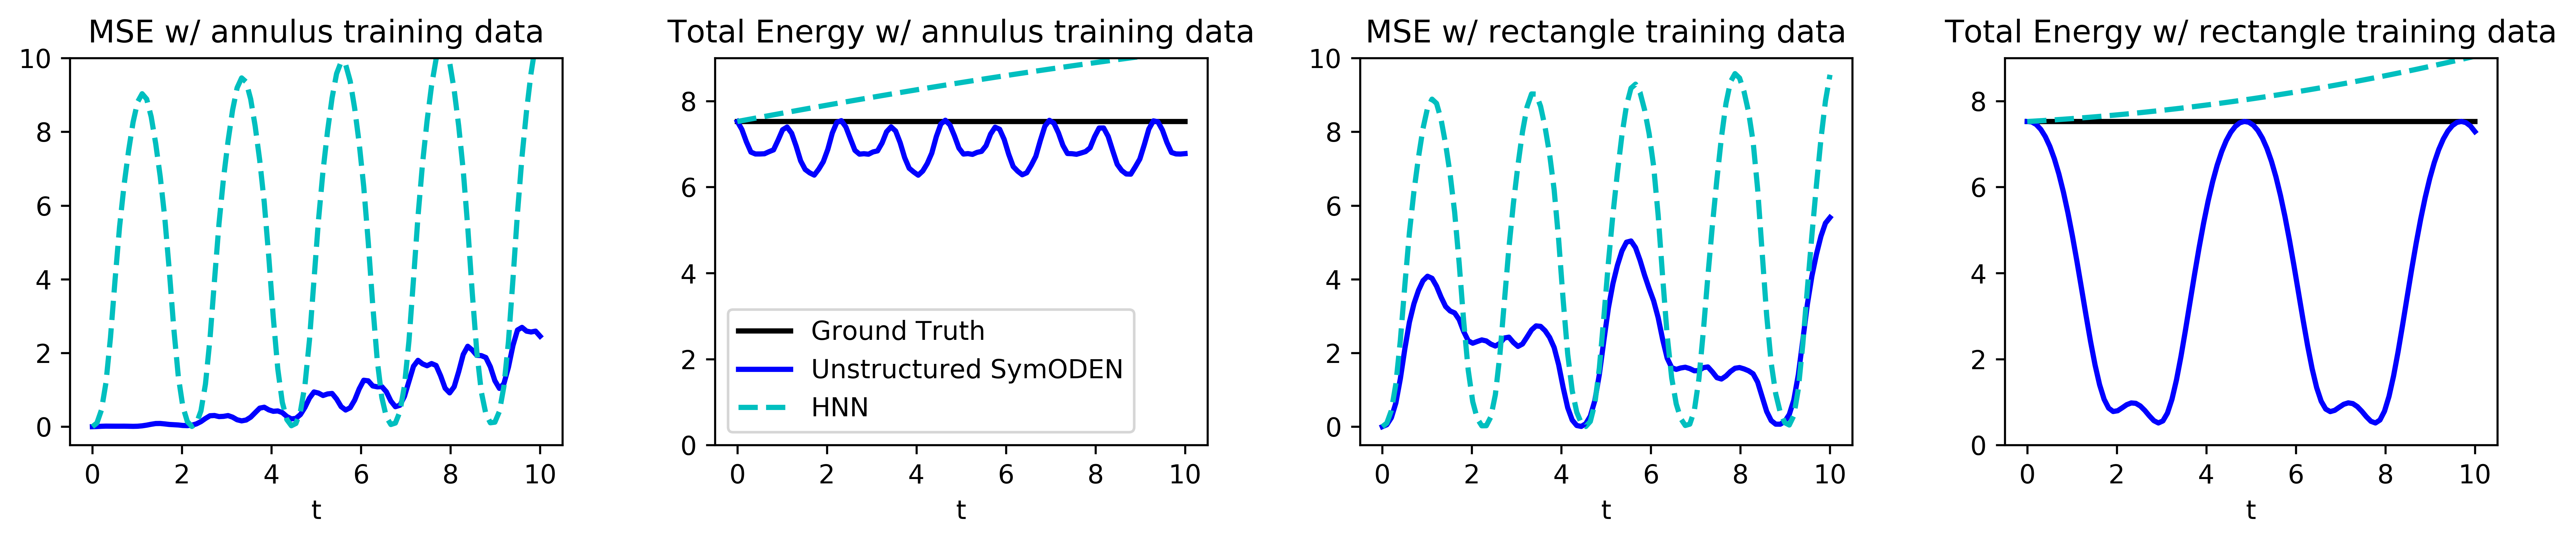

In [11]:
fig = plt.figure(figsize=(14, 3.0), dpi=DPI)
plt.subplot(1, 4, 1)
plt.plot(t_eval, ((true_x-symoden_rad_x)**2).mean(-1), 'b', linewidth=2)
plt.plot(t_eval, ((true_x[:,0:2]-hnn_rad_x)**2).mean(-1), 'c--', linewidth=2)
plt.ylim(-0.5, 10)
plt.xlabel('t')
# plt.ylabel('MSE')
plt.title('MSE w/ annulus training data')

plt.subplot(1, 4, 2)
plt.plot(t_eval, E_true, 'k', label='Ground Truth', linewidth=2)
plt.plot(t_eval, E_symoden_rad, 'b', label='Unstructured SymODEN', linewidth=2)
plt.plot(t_eval, E_hnn_rad, 'c--', label='HNN', linewidth=2)
plt.ylim(0, 9)
plt.xlabel('t')
plt.title('Total Energy w/ annulus training data')
plt.legend(fontsize=10)


plt.subplot(1, 4, 3)
plt.plot(t_eval, ((true_x-symoden_x)**2).mean(-1), 'b', linewidth=2)
plt.plot(t_eval, ((true_x[:,0:2]-hnn_x)**2).mean(-1), 'c--', linewidth=2)
plt.ylim(-0.5, 10)
plt.xlabel('t')
# plt.ylabel('MSE')
plt.title('MSE w/ rectangle training data')

plt.subplot(1, 4, 4)
plt.plot(t_eval, E_true, 'k', label='Ground Truth', linewidth=2)
plt.plot(t_eval, E_symoden, 'b', label='Unstructured SymODEN', linewidth=2)
plt.plot(t_eval, E_hnn, 'c--', label='HNN', linewidth=2)
plt.ylim(0, 9)
plt.xlabel('t')
plt.title('Total Energy w/ rectangle training data')

plt.tight_layout()
# fig.savefig('{}/fig-ablation-hnn.{}'.format(args.fig_dir, FORMAT))
